In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

# Models
import tensorflow as tf
import keras

# Metrics
from sklearn.metrics import root_mean_squared_error, r2_score, mean_absolute_error

from sklearn.model_selection import train_test_split

from utils import *

datasets_folder = './datasets'
figsize = (20,4)
verbosity = 0

metrics = [root_mean_squared_error, r2_score, mean_absolute_error, huber]

tf.config.set_visible_devices([], 'GPU')
print(tf.config.list_physical_devices('GPU'))

2025-04-26 21:27:31.301246: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-26 21:27:31.390370: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-26 21:27:31.467661: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745728051.549628   58678 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745728051.573795   58678 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1745728051.741104   58678 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

[]


2025-04-26 21:27:34.987505: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [2]:
pollution_data = read_and_preprocess_dataset(datasets_folder, 'pollution', v=verbosity)
traffic_data = read_and_preprocess_dataset(datasets_folder, 'traffic', v=verbosity, radius=2)
weather_data = read_and_preprocess_dataset(datasets_folder, 'weather', v=verbosity)

stations = sorted(pollution_data.keys())
agents = sorted(set(agent for station in stations for agent in pollution_data[station].keys()))

In [3]:
merged_traffic_data = pd.concat(
    [df.assign(Station=key) for key, df in traffic_data.items()]
)
print(merged_traffic_data.resample('1h').max().isna().sum())
merged_traffic_data

Traffic_value    0
Station          0
dtype: int64


,Traffic_value,Station
Date,,
2019-01-01 00:00:00,27629.0,GIARDINI MARGHERITA
2019-01-01 01:00:00,44430.0,GIARDINI MARGHERITA
2019-01-01 02:00:00,40318.0,GIARDINI MARGHERITA
2019-01-01 03:00:00,25661.0,GIARDINI MARGHERITA
2019-01-01 04:00:00,15906.0,GIARDINI MARGHERITA
...,...,...
2024-12-31 19:00:00,19786.0,VIA CHIARINI
2024-12-31 20:00:00,16239.0,VIA CHIARINI
2024-12-31 21:00:00,7226.0,VIA CHIARINI


In [4]:
scaler = StandardScaler()
encoded_weather_data = encode_date_index(weather_data.copy(), method='radial_months-sin-cos_days_hours')
scaled_weather_data = encoded_weather_data.copy()
scaled_weather_data[:] = scaler.fit_transform(scaled_weather_data)
print(scaled_weather_data.resample('1h').max().isna().sum())
scaled_weather_data

TAVG            0
PREC            0
RHAVG           0
RAD             0
W_SCAL_INT      0
W_VEC_DIR       0
LEAFW           0
hour_sin        0
hour_cos        0
day_sin         0
day_cos         0
month_rbf_1     0
month_rbf_2     0
month_rbf_3     0
month_rbf_4     0
month_rbf_5     0
month_rbf_6     0
month_rbf_7     0
month_rbf_8     0
month_rbf_9     0
month_rbf_10    0
month_rbf_11    0
month_rbf_12    0
dtype: int64


,TAVG,PREC,RHAVG,RAD,W_SCAL_INT,W_VEC_DIR,LEAFW,hour_sin,hour_cos,day_sin,...,month_rbf_3,month_rbf_4,month_rbf_5,month_rbf_6,month_rbf_7,month_rbf_8,month_rbf_9,month_rbf_10,month_rbf_11,month_rbf_12
Date,,,,,,,,,,,,,,,,,,,,,
2019-01-01 00:00:00,-1.746273,-0.136857,1.317050,-0.661661,-1.419546,0.045086,-0.46528,2.651432e-17,1.414173,2.846169e-01,...,-0.384179,-0.386145,-0.387749,-0.386156,-0.389161,-0.389161,-0.386156,-0.387748,-0.384695,0.102338
2019-01-01 01:00:00,-1.828240,-0.136857,1.381442,-0.661661,-1.419546,0.846485,-0.46528,3.660289e-01,1.365986,2.846169e-01,...,-0.384179,-0.386145,-0.387749,-0.386156,-0.389161,-0.389161,-0.386156,-0.387748,-0.384695,0.102338
2019-01-01 02:00:00,-1.781402,-0.136857,1.287330,-0.661661,-1.088536,-0.523648,-0.46528,7.071135e-01,1.224706,2.846169e-01,...,-0.384179,-0.386145,-0.387749,-0.386156,-0.389161,-0.389161,-0.386156,-0.387748,-0.384695,0.102338
2019-01-01 03:00:00,-1.816531,-0.136857,1.277424,-0.661661,-1.309209,-0.171842,-0.46528,1.000010e+00,0.999964,2.846169e-01,...,-0.384179,-0.386145,-0.387749,-0.386156,-0.389161,-0.389161,-0.386156,-0.387748,-0.384695,0.102338
2019-01-01 04:00:00,-1.746273,-0.136857,1.019854,-0.661661,-1.309209,-0.357299,-0.46528,1.224757e+00,0.707073,2.846169e-01,...,-0.384179,-0.386145,-0.387749,-0.386156,-0.389161,-0.389161,-0.386156,-0.387748,-0.384695,0.102338
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-30 20:00:00,-1.137371,-0.136857,0.316492,-0.661661,-0.592021,0.721724,-0.46528,-1.224757e+00,0.707073,-2.846169e-01,...,-0.385392,-0.386145,-0.387749,-0.386156,-0.389161,-0.389161,-0.386155,-0.386535,0.110896,3.237990
2024-12-30 21:00:00,-1.207629,-0.136857,0.514622,-0.661661,-0.316180,0.599209,-0.46528,-1.000010e+00,0.999964,-2.846169e-01,...,-0.385392,-0.386145,-0.387749,-0.386156,-0.389161,-0.389161,-0.386155,-0.386535,0.110896,3.237990
2024-12-30 22:00:00,-1.195919,-0.136857,0.474996,-0.661661,-0.150675,0.555374,-0.46528,-7.071135e-01,1.224706,-2.846169e-01,...,-0.385392,-0.386145,-0.387749,-0.386156,-0.389161,-0.389161,-0.386155,-0.386535,0.110896,3.237990


In [5]:
scaler = StandardScaler()
scaled_traffic_data = merged_traffic_data.copy()
scaled_traffic_data['Traffic_value'] = scaler.fit_transform(merged_traffic_data[['Traffic_value']])
scaled_traffic_data

,Traffic_value,Station
Date,,
2019-01-01 00:00:00,-0.366692,GIARDINI MARGHERITA
2019-01-01 01:00:00,0.111507,GIARDINI MARGHERITA
2019-01-01 02:00:00,-0.005531,GIARDINI MARGHERITA
2019-01-01 03:00:00,-0.422706,GIARDINI MARGHERITA
2019-01-01 04:00:00,-0.700359,GIARDINI MARGHERITA
...,...,...
2024-12-31 19:00:00,-0.589924,VIA CHIARINI
2024-12-31 20:00:00,-0.690881,VIA CHIARINI
2024-12-31 21:00:00,-0.947414,VIA CHIARINI


In [6]:
for station in stations:
    for agent, d_agent_values in pollution_data[station].items():
        num = d_agent_values.isna().sum()['Agent_value']
        if num > 0:
            print(f'Found {num} nan values in {agent}-{station}')
        pollution_data[station][agent] = d_agent_values.dropna()
        
for station in stations:
    print(station)
    for agent, d_agent_values in pollution_data[station].items():
        print(f'{agent}, mean:{d_agent_values.mean().values}, std:{d_agent_values.std().values}')

Found 12 nan values in PM2.5-GIARDINI MARGHERITA
GIARDINI MARGHERITA
NO2, mean:[17.1419415], std:[12.5876588]
O3, mean:[48.9717251], std:[37.84998337]
PM10, mean:[22.27748691], std:[14.5251379]
PM2.5, mean:[14.08609272], std:[11.68323701]
PORTA SAN FELICE
C6H6, mean:[0.96896855], std:[0.7330824]
CO, mean:[0.57857764], std:[0.31027021]
NO2, mean:[39.71149519], std:[19.29119846]
PM10, mean:[25.36431574], std:[15.49784178]
PM2.5, mean:[15.63339552], std:[11.86983867]
VIA CHIARINI
NO2, mean:[17.89645159], std:[13.34144142]
O3, mean:[44.2898427], std:[38.50621494]
PM10, mean:[22.30033003], std:[13.79587869]


In [7]:
agent_distributions = {} # dict agent:tuple[mean, std]

for agent in agents:
    aux = pd.concat([pollution_data[station][agent] for station in stations if agent in pollution_data[station]])
    agent_distributions[agent] = (aux.mean().values[0], aux.std().values[0])

agent_distributions

{'C6H6': (np.float64(0.9689685475465452), np.float64(0.7330824010407067)),
 'CO': (np.float64(0.5785776353138818), np.float64(0.3102702077783253)),
 'NO2': (np.float64(24.915181486150168), np.float64(18.59322783085418)),
 'O3': (np.float64(46.63493093000068), np.float64(38.2504439439507)),
 'PM10': (np.float64(23.323746660380323), np.float64(14.695789140629058)),
 'PM2.5': (np.float64(14.865194927195867), np.float64(11.801572000736279))}

In [8]:
normalized_pollution_data = pollution_data.copy()

for station in stations:
    for agent in normalized_pollution_data[station]:
        normalized_pollution_data[station][agent] = (normalized_pollution_data[station][agent] - agent_distributions[agent][0]) / agent_distributions[agent][1]

for agent in agents:
    aux = pd.concat([normalized_pollution_data[station][agent] for station in stations if agent in normalized_pollution_data[station]])
    print(agent, round(aux.mean().values[0], 2), round(aux.std().values[0], 2))

C6H6 -0.0 1.0
CO 0.0 1.0
NO2 -0.0 1.0
O3 -0.0 1.0
PM10 0.0 1.0
PM2.5 -0.0 1.0


In [9]:
station_data = {
    station: pd.merge(
        scaled_traffic_data[scaled_traffic_data['Station'] == station].drop(columns=['Station']),
        scaled_weather_data,
        left_index=True,
        right_index=True
    )
    for station in stations
}
for station in station_data:
    display(station, station_data[station].head(3))

'GIARDINI MARGHERITA'

,Traffic_value,TAVG,PREC,RHAVG,RAD,W_SCAL_INT,W_VEC_DIR,LEAFW,hour_sin,hour_cos,...,month_rbf_3,month_rbf_4,month_rbf_5,month_rbf_6,month_rbf_7,month_rbf_8,month_rbf_9,month_rbf_10,month_rbf_11,month_rbf_12
Date,,,,,,,,,,,,,,,,,,,,,
2019-01-01 00:00:00,-0.366692,-1.746273,-0.136857,1.317050,-0.661661,-1.419546,0.045086,-0.46528,2.651432e-17,1.414173,...,-0.384179,-0.386145,-0.387749,-0.386156,-0.389161,-0.389161,-0.386156,-0.387748,-0.384695,0.102338
2019-01-01 01:00:00,0.111507,-1.828240,-0.136857,1.381442,-0.661661,-1.419546,0.846485,-0.46528,3.660289e-01,1.365986,...,-0.384179,-0.386145,-0.387749,-0.386156,-0.389161,-0.389161,-0.386156,-0.387748,-0.384695,0.102338
2019-01-01 02:00:00,-0.005531,-1.781402,-0.136857,1.287330,-0.661661,-1.088536,-0.523648,-0.46528,7.071135e-01,1.224706,...,-0.384179,-0.386145,-0.387749,-0.386156,-0.389161,-0.389161,-0.386156,-0.387748,-0.384695,0.102338


'PORTA SAN FELICE'

,Traffic_value,TAVG,PREC,RHAVG,RAD,W_SCAL_INT,W_VEC_DIR,LEAFW,hour_sin,hour_cos,...,month_rbf_3,month_rbf_4,month_rbf_5,month_rbf_6,month_rbf_7,month_rbf_8,month_rbf_9,month_rbf_10,month_rbf_11,month_rbf_12
Date,,,,,,,,,,,,,,,,,,,,,
2019-01-01 00:00:00,0.011177,-1.746273,-0.136857,1.317050,-0.661661,-1.419546,0.045086,-0.46528,2.651432e-17,1.414173,...,-0.384179,-0.386145,-0.387749,-0.386156,-0.389161,-0.389161,-0.386156,-0.387748,-0.384695,0.102338
2019-01-01 01:00:00,0.599669,-1.828240,-0.136857,1.381442,-0.661661,-1.419546,0.846485,-0.46528,3.660289e-01,1.365986,...,-0.384179,-0.386145,-0.387749,-0.386156,-0.389161,-0.389161,-0.386156,-0.387748,-0.384695,0.102338
2019-01-01 02:00:00,0.316324,-1.781402,-0.136857,1.287330,-0.661661,-1.088536,-0.523648,-0.46528,7.071135e-01,1.224706,...,-0.384179,-0.386145,-0.387749,-0.386156,-0.389161,-0.389161,-0.386156,-0.387748,-0.384695,0.102338


'VIA CHIARINI'

,Traffic_value,TAVG,PREC,RHAVG,RAD,W_SCAL_INT,W_VEC_DIR,LEAFW,hour_sin,hour_cos,...,month_rbf_3,month_rbf_4,month_rbf_5,month_rbf_6,month_rbf_7,month_rbf_8,month_rbf_9,month_rbf_10,month_rbf_11,month_rbf_12
Date,,,,,,,,,,,,,,,,,,,,,
2019-01-01 00:00:00,-0.913856,-1.746273,-0.136857,1.317050,-0.661661,-1.419546,0.045086,-0.46528,2.651432e-17,1.414173,...,-0.384179,-0.386145,-0.387749,-0.386156,-0.389161,-0.389161,-0.386156,-0.387748,-0.384695,0.102338
2019-01-01 01:00:00,-0.724523,-1.828240,-0.136857,1.381442,-0.661661,-1.419546,0.846485,-0.46528,3.660289e-01,1.365986,...,-0.384179,-0.386145,-0.387749,-0.386156,-0.389161,-0.389161,-0.386156,-0.387748,-0.384695,0.102338
2019-01-01 02:00:00,-0.787369,-1.781402,-0.136857,1.287330,-0.661661,-1.088536,-0.523648,-0.46528,7.071135e-01,1.224706,...,-0.384179,-0.386145,-0.387749,-0.386156,-0.389161,-0.389161,-0.386156,-0.387748,-0.384695,0.102338


In [26]:
input_features = station_data[stations[0]]
input_features[f'{stations[1]}_Traffic_value'] = station_data[stations[1]]['Traffic_value']
input_features[f'{stations[2]}_Traffic_value'] = station_data[stations[2]]['Traffic_value']
input_features

,Traffic_value,TAVG,PREC,RHAVG,RAD,W_SCAL_INT,W_VEC_DIR,LEAFW,hour_sin,hour_cos,...,month_rbf_5,month_rbf_6,month_rbf_7,month_rbf_8,month_rbf_9,month_rbf_10,month_rbf_11,month_rbf_12,PORTA SAN FELICE_Traffic_value,VIA CHIARINI_Traffic_value
Date,,,,,,,,,,,,,,,,,,,,,
2019-01-01 00:00:00,-0.366692,-1.746273,-0.136857,1.317050,-0.661661,-1.419546,0.045086,-0.46528,2.651432e-17,1.414173,...,-0.387749,-0.386156,-0.389161,-0.389161,-0.386156,-0.387748,-0.384695,0.102338,0.011177,-0.913856
2019-01-01 01:00:00,0.111507,-1.828240,-0.136857,1.381442,-0.661661,-1.419546,0.846485,-0.46528,3.660289e-01,1.365986,...,-0.387749,-0.386156,-0.389161,-0.389161,-0.386156,-0.387748,-0.384695,0.102338,0.599669,-0.724523
2019-01-01 02:00:00,-0.005531,-1.781402,-0.136857,1.287330,-0.661661,-1.088536,-0.523648,-0.46528,7.071135e-01,1.224706,...,-0.387749,-0.386156,-0.389161,-0.389161,-0.386156,-0.387748,-0.384695,0.102338,0.316324,-0.787369
2019-01-01 03:00:00,-0.422706,-1.816531,-0.136857,1.277424,-0.661661,-1.309209,-0.171842,-0.46528,1.000010e+00,0.999964,...,-0.387749,-0.386156,-0.389161,-0.389161,-0.386156,-0.387748,-0.384695,0.102338,-0.204000,-0.932357
2019-01-01 04:00:00,-0.700359,-1.746273,-0.136857,1.019854,-0.661661,-1.309209,-0.357299,-0.46528,1.224757e+00,0.707073,...,-0.387749,-0.386156,-0.389161,-0.389161,-0.386156,-0.387748,-0.384695,0.102338,-0.524062,-1.002973
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-30 20:00:00,-0.105207,-1.137371,-0.136857,0.316492,-0.661661,-0.592021,0.721724,-0.46528,-1.224757e+00,0.707073,...,-0.387749,-0.386156,-0.389161,-0.389161,-0.386155,-0.386535,0.110896,3.237990,0.281116,-0.786942
2024-12-30 21:00:00,-0.589895,-1.207629,-0.136857,0.514622,-0.661661,-0.316180,0.599209,-0.46528,-1.000010e+00,0.999964,...,-0.387749,-0.386156,-0.389161,-0.389161,-0.386155,-0.386535,0.110896,3.237990,-0.341389,-0.929738
2024-12-30 22:00:00,-0.601195,-1.195919,-0.136857,0.474996,-0.661661,-0.150675,0.555374,-0.46528,-7.071135e-01,1.224706,...,-0.387749,-0.386156,-0.389161,-0.389161,-0.386155,-0.386535,0.110896,3.237990,-0.318334,-0.921513


In [10]:
hourly_time_steps = 3
daily_time_steps = 24

In [27]:
sequences, dates = create_sequences(
    input_features,
    pd.Series(input_features.index, index=input_features.index),
    time_steps=hourly_time_steps
)

In [11]:
station_sliding_windows = {}
for station in station_data:
    sequences, dates = create_sequences(
        station_data[station],
        pd.Series(station_data[station].index, index=station_data[station].index),
        time_steps=hourly_time_steps
    )
    dates = dates.index.tolist()
    station_sliding_windows[station] = sequences, dates

In [12]:
station_sequences = {}
for station in station_data:
    sequences, dates = create_sequences(
        station_data[station].drop(columns=['hour_sin', 'hour_cos']),
        pd.Series(station_data[station].index, index=station_data[station].index),
        time_steps=daily_time_steps,
        sliding_window=False
    ) 
    station_sequences[station] = sequences, dates

In [67]:
all_dfs = []

for station_name, agents_dict in pollution_data.items():
    station_df = pd.concat({agent: df.squeeze() for agent, df in agents_dict.items() if agent not in ('PM2.5','PM10')}, axis=1)
    
    station_df = station_df.rename(columns=lambda agent: f"{station_name.replace(' ','_')}_{agent}")
    
    all_dfs.append(station_df)

final_df = pd.concat(all_dfs, axis=1)
final_df = final_df.iloc[3:]
final_df

,GIARDINI_MARGHERITA_NO2,GIARDINI_MARGHERITA_O3,PORTA_SAN_FELICE_C6H6,PORTA_SAN_FELICE_CO,PORTA_SAN_FELICE_NO2,VIA_CHIARINI_NO2,VIA_CHIARINI_O3
Date,,,,,,,
2019-01-01 03:00:00,0.219694,-1.166913,5.089512,3.936641,NaN,-0.479485,-1.193056
2019-01-01 04:00:00,0.058345,-1.166913,4.953101,3.936641,0.757524,NaN,NaN
2019-01-01 05:00:00,-0.049221,-1.166913,4.816691,3.614341,0.757524,-0.049221,-1.219200
2019-01-01 06:00:00,-0.103004,-1.166913,4.407460,3.292041,0.865090,-0.479485,-1.166913
2019-01-01 07:00:00,0.112128,-1.166913,3.588998,2.325142,0.488609,-0.533268,-1.193056
...,...,...,...,...,...,...,...
2024-12-31 19:00:00,-0.103004,-0.748617,1.815664,1.358243,0.596175,0.865090,-1.166913
2024-12-31 20:00:00,-0.156787,-0.905478,1.542844,0.713644,0.488609,0.703741,-1.114626
2024-12-31 21:00:00,-0.371919,-0.408752,0.997202,0.391344,0.165911,0.381043,-0.983908


In [68]:
# Define the split date
val_split_date = '2023-06-30'
split_date = '2023-12-31'
dataset = {'date': final_df.index,
           'input_features':sequences,
           'output':{f'{output_name}_output':final_df[output_name].fillna(0) for output_name in final_df.columns}}

train_dataset = {
    'date': final_df.loc[:val_split_date].index,
    'input_features': sequences[:len(final_df.loc[:val_split_date])],
    'output': {key: value.loc[:val_split_date] for key, value in dataset['output'].items()}
}

val_split_date = '2023-07-01'
val_dataset = {
    'date': final_df.loc[val_split_date:split_date].index,
    'input_features': sequences[len(final_df.loc[:val_split_date])-24:len(final_df.loc[:split_date])],
    'output': {key: value.loc[val_split_date:split_date] for key, value in dataset['output'].items()}
}
split_date = '2024-01-01'

test_dataset = {
    'date': final_df.loc[split_date:].index,
    'input_features': sequences[len(final_df.loc[:split_date])-24:],
    'output': {key: value.loc[split_date:] for key, value in dataset['output'].items()}
}

In [69]:
print(dataset['input_features'].shape, dataset['output']['PORTA_SAN_FELICE_NO2_output'].shape)
print(train_dataset['input_features'].shape, train_dataset['output']['PORTA_SAN_FELICE_NO2_output'].shape)
print(val_dataset['input_features'].shape, val_dataset['output']['PORTA_SAN_FELICE_NO2_output'].shape)
print(test_dataset['input_features'].shape, test_dataset['output']['PORTA_SAN_FELICE_NO2_output'].shape)

(52583, 3, 26) (52598,)
(39399, 3, 26) (39399,)
(4416, 3, 26) (4416,)
(8768, 3, 26) (8783,)


In [74]:
input_shape = (3, 26)
inputs = tf.keras.layers.Input(shape=input_shape, name='input')

x = tf.keras.layers.LSTM(64, return_sequences=True)(inputs)
x = tf.keras.layers.LSTM(64, return_sequences=False)(inputs)
embedding_layer = tf.keras.layers.Dense(64, activation='relu', name='embedding')(x)
head_outputs = []
for c in final_df.columns:
    dense_layer = tf.keras.layers.Dense(16, activation='tanh', name=f'{c}_dense')(embedding_layer)
    head = tf.keras.layers.Dense(1, name=f'{c}_output')(dense_layer) 
    head_outputs.append(head)

# Build model
model = tf.keras.Model(inputs=inputs, outputs=head_outputs)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-2),
    loss={f'{c}_output': 'mse' for c in final_df.columns},
    loss_weights={f'{c}_output': 0.1428 for c in final_df.columns},
    metrics={f'{c}_output': 'mae' for c in final_df.columns}
)


In [75]:
model.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)  │ (None, 3, 26)     │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_13 (LSTM)      │ (None, 64)        │     23,296 │ input[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding (Dense)   │ (None, 64)        │      4,160 │ lstm_13[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ GIARDINI_MARGHERIT… │ (None, 16)        │      1,040 │ embedding[0][0]   │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ GIARDINI_MARGHERIT… │ (None, 16)        │      1,040 │ embedding[0][0]   │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ PORTA_SAN_FELICE_C… │ (None, 16)        │      1,040 │ embedding[0][0]   │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ PORTA_SAN_FELICE_C… │ (None, 16)        │      1,040 │ embedding[0][0]   │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ PORTA_SAN_FELICE_N… │ (None, 16)        │      1,040 │ embedding[0][0]   │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ VIA_CHIARINI_NO2_d… │ (None, 16)        │      1,040 │ embedding[0][0]   │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ VIA_CHIARINI_O3_de… │ (None, 16)        │      1,040 │ embedding[0][0]   │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ GIARDINI_MARGHERIT… │ (None, 1)         │         17 │ GIARDINI_MARGHER… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ GIARDINI_MARGHERIT… │ (None, 1)         │         17 │ GIARDINI_MARGHER… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ PORTA_SAN_FELICE_C… │ (None, 1)         │         17 │ PORTA_SAN_FELICE… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ PORTA_SAN_FELICE_C… │ (None, 1)         │         17 │ PORTA_SAN_FELICE… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ PORTA_SAN_FELICE_N… │ (None, 1)         │         17 │ PORTA_SAN_FELICE… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ VIA_CHIARINI_NO2_o… │ (None, 1)         │         17 │ VIA_CHIARINI_NO2… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ VIA_CHIARINI_O3_ou… │ (None, 1)         │         17 │ VIA_CHIARINI_O3_… │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 34,855 (136.15 KB)

 Trainable params: 34,855 (136.15 KB)

 Non-trainable params: 0 (0.00 B)

In [76]:
callbacks = [
    keras.callbacks.ReduceLROnPlateau(
        factor=0.1,
        patience=5,
        min_lr=1e-4,
        verbose=1
    )
]
history = model.fit(
    train_dataset['input_features'],
    train_dataset['output'],
    validation_data=(val_dataset['input_features'], val_dataset['output']),
    epochs=30,
    batch_size=32,
    verbose=1,
    callbacks=callbacks
)

Epoch 1/30
1232/1232 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - GIARDINI_MARGHERITA_NO2_output_loss: 0.2235 - GIARDINI_MARGHERITA_NO2_output_mae: 0.3521 - GIARDINI_MARGHERITA_O3_output_loss: 0.2388 - GIARDINI_MARGHERITA_O3_output_mae: 0.3695 - PORTA_SAN_FELICE_C6H6_output_loss: 0.5469 - PORTA_SAN_FELICE_C6H6_output_mae: 0.4559 - PORTA_SAN_FELICE_CO_output_loss: 0.5110 - PORTA_SAN_FELICE_CO_output_mae: 0.5431 - PORTA_SAN_FELICE_NO2_output_loss: 0.6210 - PORTA_SAN_FELICE_NO2_output_mae: 0.6064 - VIA_CHIARINI_NO2_output_loss: 0.2690 - VIA_CHIARINI_NO2_output_mae: 0.3818 - VIA_CHIARINI_O3_output_loss: 0.2469 - VIA_CHIARINI_O3_output_mae: 0.3784 - loss: 0.3794 - val_GIARDINI_MARGHERITA_NO2_output_loss: 0.1966 - val_GIARDINI_MARGHERITA_NO2_output_mae: 0.3446 - val_GIARDINI_MARGHERITA_O3_output_loss: 0.4421 - val_GIARDINI_MARGHERITA_O3_output_mae: 0.5014 - val_PORTA_SAN_FELICE_C6H6_output_loss: 0.4932 - val_PORTA_SAN_FELICE_C6H6_output_mae: 0.4857 - val_PORTA_SAN_FELICE_CO_output_loss: 0.6856 - val_

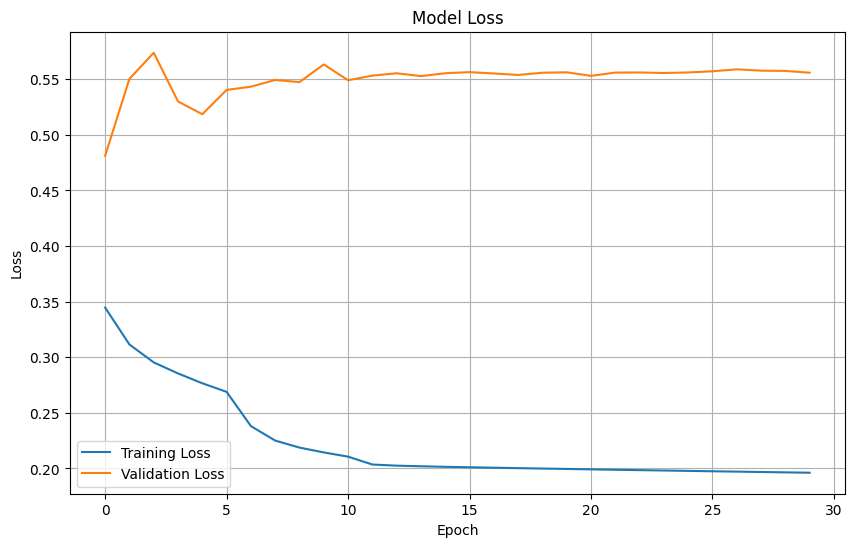

In [72]:
# Plot training & validation loss values
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot training & validation MAE values (if available)
if 'mae' in history.history:
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['mae'], label='Training MAE')
    plt.plot(history.history['val_mae'], label='Validation MAE')
    plt.title('Model Mean Absolute Error')
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.legend()
    plt.grid(True)
    plt.show()

In [80]:
embedder = tf.keras.Model(
    inputs=model.input,
    outputs=model.get_layer('embedding').output
)
train_embeddings = embedder.predict(train_dataset['input_features'])

1232/1232 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step  


In [90]:
from sklearn.metrics import mean_squared_error


xgboost_models = {}

# Train an XGBoost regressor for each column in final_df
for column in final_df.columns:
    y = final_df[column].fillna(0).loc[train_dataset['date']]  # Use the corresponding values for training
    model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, max_depth=5, learning_rate=0.1)
    model.fit(train_embeddings, y)
    xgboost_models[column] = model

print("XGBoost models trained for each column in final_df.")

# Dictionary to store training and validation results
results = {}
# Train, predict, and calculate MSE for each column in final_df
for column in final_df.columns:
    # Prepare training data
    y_train = final_df[column].fillna(0).loc[train_dataset['date']]  # Use the corresponding values for training
    xgboost_models[column].fit(train_embeddings[:len(y_train)], y_train)  # Train the model

    # Prepare validation data
    y_val = final_df[column].fillna(0).loc[val_dataset['date']]  # Use the corresponding values for validation
    y_pred = xgboost_models[column].predict(train_embeddings[:len(y_val)])  # Predict using the trained model

    # Calculate MSE for validation
    mse = mean_squared_error(y_val, y_pred)

    # Store results
    results[column] = {
        'training': {'model': xgboost_models[column]},
        'validation': {'mse': mse, 'predictions': y_pred}
    }

    print(f"{column}: MSE = {mse}")


XGBoost models trained for each column in final_df.
GIARDINI_MARGHERITA_NO2: MSE = 1.2319845263342626
GIARDINI_MARGHERITA_O3: MSE = 2.833903824632836
PORTA_SAN_FELICE_C6H6: MSE = 2.3885005552800864
PORTA_SAN_FELICE_CO: MSE = 2.720918356262317
PORTA_SAN_FELICE_NO2: MSE = 1.9526633280484065
VIA_CHIARINI_NO2: MSE = 1.3334908066842643
VIA_CHIARINI_O3: MSE = 2.7620692173643655
